In [1]:
from module import td3

import tensorflow as tf
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.models import Sequential

import numpy as np
import random
import gym
import matplotlib.pyplot as plt

from collections import deque

In [2]:
env = gym.make("LunarLander-v2", continuous=True)

# Get the state and action sizes
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

print(state_size, action_size)

8 2


In [3]:
state = env.reset()
state = np.reshape(state[0], [1, state_size])
done = False
score = 0
for i in range(100):
    env.render()
    # select action
    action = np.random.uniform(low=-1, high=1, size=(4,))
    # perform the action
    next_state, reward, done, _, _= env.step(action)
    # update the score
    score += reward
    # move to the next state
    next_state = np.reshape(next_state, [1, state_size])
    state = next_state

score

/Users/sondinhvan/miniconda3/envs/rl_env/lib/python3.9/site-packages/gym/envs/box2d/lunar_lander.py:604: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("LunarLander-v2", render_mode="rgb_array")
  gym.logger.warn(
/Users/sondinhvan/miniconda3/envs/rl_env/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


-133.6996575254518

In [4]:
# training
env = gym.make("LunarLander-v2", continuous=True)
agent = td3.TD3Agent(state_size, action_size,
                       gamma=0.995, batch_size=128,
                       update_period=2, training_start=1000,
                       noise_std=0.1, noise_decay=0.995,
                       noise_boundary=0.3, min_noise_std=0.05,
                       lr_actor=0.005, lr_critic=0.005)
score_history = []
avg_score_history = []

n_episodes = 20000

for i in range(n_episodes):
    agent.noise_std = max(agent.noise_std * agent.noise_decay, agent.min_noise_std)
    done = False
    score = 0
    state = env.reset()
    state = np.reshape(state[0], [1, state_size])
    time_step = 0  # to count number of steps the ship takes to land
    while not done:
        time_step += 1
        action = agent.act(state, use_noise=False, noise_label='Gaussian')
        next_state, reward, done, _, _ = env.step(action)
        next_state = next_state.reshape(1, state_size)
        if not done:
            # penalize each stop to avoid hovering
            shaped_reward = reward - 0.1 * 1.001**time_step
        agent.store_data(state, action, shaped_reward, next_state, done)
        agent.learn()
        state = next_state
        score += reward
        
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    avg_score_history.append(avg_score)
    print('Episode ', i, '- score ', round(score, 3), '- average score ', round(avg_score, 3), '- noise dev', round(agent.noise_std, 3), '- timestep ', time_step )
    

Episode  0 - score  -156.372 - average score  -156.372 - noise dev 0.1 - timestep  69
Episode  1 - score  -350.32 - average score  -253.346 - noise dev 0.099 - timestep  136
Episode  2 - score  -261.964 - average score  -256.219 - noise dev 0.099 - timestep  121
Episode  3 - score  -271.246 - average score  -259.976 - noise dev 0.098 - timestep  135
Episode  4 - score  -193.314 - average score  -246.643 - noise dev 0.098 - timestep  95
Episode  5 - score  -152.609 - average score  -230.971 - noise dev 0.097 - timestep  90
Episode  6 - score  -136.447 - average score  -217.467 - noise dev 0.097 - timestep  58
Episode  7 - score  -272.996 - average score  -224.408 - noise dev 0.096 - timestep  110
Episode  8 - score  -168.293 - average score  -218.173 - noise dev 0.096 - timestep  72
Collect enough samples, training starting
Episode  9 - score  -145.405 - average score  -210.896 - noise dev 0.095 - timestep  151
Episode  10 - score  -498.859 - average score  -237.075 - noise dev 0.095 - 

KeyboardInterrupt: 

In [13]:
env = gym.make("LunarLander-v2", continuous=True, render_mode='human')
state = env.reset()
state = np.reshape(state[0], [1, state_size])
done = False
score = 0
while not done:
    action = agent.act(state, use_noise=False)
    next_state, reward, done, _, _ = env.step(action)
    next_state = next_state.reshape(1, state_size)
    
    state = next_state
    score += reward

print(score)

259.4369895073793


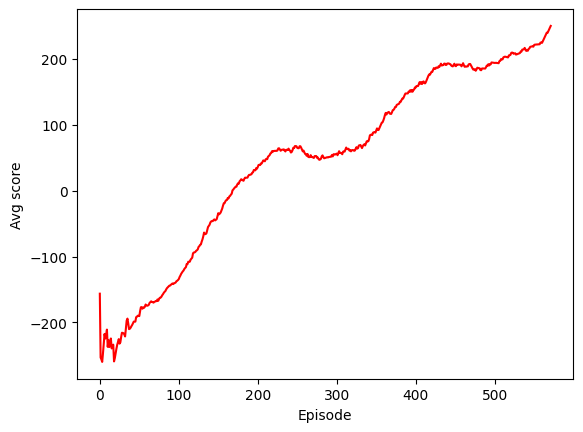

In [11]:
plt.plot(avg_score_history, color='red')
plt.xlabel('Episode')
plt.ylabel('Avg score')
plt.savefig('TD3_LunarLander_continuous')